# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from numpy import linalg  as LA

import warnings
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import sklearn
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse 

RND = 12345

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.shape

(354369, 16)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Столбец Price имеет нули, их можно удалить.
Столбец Power имеет нули, их можно удалить.
В столбце RegistrationYear есть данные не похожие на года, т.е 1000 и 9999, нужно понять сколько их  и удалить те, что не соответствуют годам регистрации.
Столбец NumberOfPictures все нули, удаляем.
Также есть столбцы с датами, удалим их.
Столбцы почтовый индекс и дата последней активности тоже не несут смысловой нагрузки. Удаляем

In [6]:
data = data.drop(['DateCreated','LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

In [7]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')


,0
DateCrawled,0.00%
Price,0.00%
RegistrationYear,0.00%
Power,0.00%
Kilometer,0.00%
RegistrationMonth,0.00%
Brand,0.00%
Model,5.56%
Gearbox,5.60%
FuelType,9.28%


In [10]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [11]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

In [12]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [13]:
data = data[(data['RegistrationYear'] > 1970) & (data['RegistrationYear'] < 2017)]

In [14]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1971, 1987, 1986, 1988, 1974, 1979, 1978, 1972,
       1977, 1975])

In [15]:
data['Model'] = data['Model'].fillna(value = 'unknown')
data['Gearbox'] = data['Gearbox'].fillna(value = 'unknown')
data['FuelType'] = data['FuelType'].fillna(value = 'unknown')
data['VehicleType'] = data['VehicleType'].fillna(value = 'unknown')


In [16]:
data['Repaired'].unique()


array([nan, 'yes', 'no'], dtype=object)

In [17]:
data['Repaired'] = data['Repaired'].fillna(value = 'no')

In [18]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
DateCrawled,0.00%
Price,0.00%
VehicleType,0.00%
RegistrationYear,0.00%
Gearbox,0.00%
Power,0.00%
Model,0.00%
Kilometer,0.00%
RegistrationMonth,0.00%
FuelType,0.00%


In [19]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,338168.000000,338168.000000,338168.000000,338168.000000,338168.000000
mean,4461.461522,2002.684358,111.217185,128336.359443,5.765918
std,4535.407928,6.385945,185.151538,37627.542809,3.706365
min,0.000000,1971.000000,0.000000,5000.000000,0.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


In [20]:
data['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,   132,   234,   158,    39,    92,    51,   135,    59,
          53,   209,

In [21]:
data['Price'].unique()

array([  480, 18300,  9800, ..., 12395, 18429, 10985])

In [22]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [23]:
data = data.drop(['RegistrationMonth','DateCrawled'], axis=1)

Удалим нулевые знаения в этих столбцах и посмотрим, есть ли выбросы.

In [24]:
data = data[data['Price'] != 0]
data = data[data['Power'] != 0]


In [25]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,296041.000000,296041.000000,296041.000000,296041.000000
mean,4841.269088,2002.928696,124.308076,128398.769089
std,4602.973052,6.192611,188.747049,36681.211962
min,1.000000,1971.000000,1.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,3199.000000,2003.000000,111.000000,150000.000000
75%,6990.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


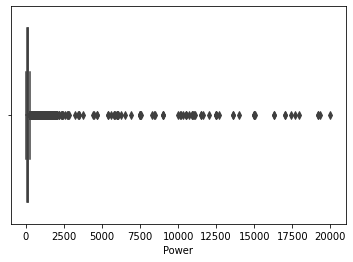

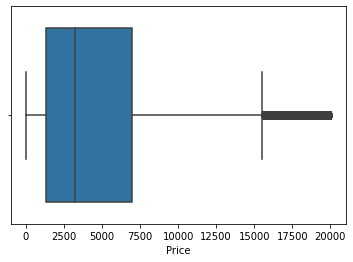

In [26]:
for a in ['Power','Price']:
    sns.boxplot(data[a]) 
    plt.show()

Гугл нам говорит, что есть маломощные автомобили, но с мощностью 0 автомобилей нет. А самые мощные примерно 1500 л.с. Оставим автомобили  с мощностью 50-1500 л.с.


In [27]:
data = data[(data['Power'] < 1000) & (data['Power'] > 50)]

In [28]:
data['Power'].describe()

count    286306.000000
mean        123.309885
std          53.634730
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

По цене есть аномальные значения, но никто не мешает владельцу их устанавливать. Так что оставим, как есть.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286306 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             286306 non-null  int64 
 1   VehicleType       286306 non-null  object
 2   RegistrationYear  286306 non-null  int64 
 3   Gearbox           286306 non-null  object
 4   Power             286306 non-null  int64 
 5   Model             286306 non-null  object
 6   Kilometer         286306 non-null  int64 
 7   FuelType          286306 non-null  object
 8   Brand             286306 non-null  object
 9   Repaired          286306 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.0+ MB


In [30]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [31]:
columns=['Price', 'VehicleType', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired',]

In [32]:
data_model= data[columns].copy()

In [33]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286306 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Price        286306 non-null  int64 
 1   VehicleType  286306 non-null  object
 2   Gearbox      286306 non-null  object
 3   Power        286306 non-null  int64 
 4   Model        286306 non-null  object
 5   Kilometer    286306 non-null  int64 
 6   FuelType     286306 non-null  object
 7   Brand        286306 non-null  object
 8   Repaired     286306 non-null  object
dtypes: int64(3), object(6)
memory usage: 21.8+ MB


In [34]:
data_model=data_model.reset_index(drop=True)

In [35]:
target = data_model['Price']
features = data_model.drop('Price', axis = 1)

In [36]:
features.columns

Index(['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType',
       'Brand', 'Repaired'],
      dtype='object')

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train_valid, features_test_valid,target_train_valid, target_test_valid = train_test_split(features_test,target_test, test_size=0.5, random_state=RND)

In [38]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'Repaired']
numeric = [ 'Power', 'Kilometer']

In [39]:
encoder= OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test[cat_columns] = encoder.fit_transform(features_test[cat_columns])

Масштабируем признаки

In [40]:

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [41]:
print(features_train.shape)
print(features_test.shape)

(214729, 8)
(71577, 8)


Данные подготовлены к обучению

## Обучение моделей

XGBRegressor

In [42]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [2,6,3], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[RND], 
         
         }
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(features_test, target_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_


In [43]:
%%time
xgb_params = xgb_regr(features_train, target_train)

[0]	validation_0-rmse:4624.80518
[10]	validation_0-rmse:2895.30762
[20]	validation_0-rmse:2805.69312
[30]	validation_0-rmse:2754.98755
[40]	validation_0-rmse:2719.74292
[50]	validation_0-rmse:2703.26147
[60]	validation_0-rmse:2673.44385
[70]	validation_0-rmse:2656.93799
[80]	validation_0-rmse:2652.03809
[90]	validation_0-rmse:2644.73193
[99]	validation_0-rmse:2636.38818
[0]	validation_0-rmse:4628.61328
[10]	validation_0-rmse:2894.55811
[20]	validation_0-rmse:2786.97510
[30]	validation_0-rmse:2740.63892
[40]	validation_0-rmse:2716.20923
[50]	validation_0-rmse:2688.33594
[60]	validation_0-rmse:2681.61963
[70]	validation_0-rmse:2668.90918
[80]	validation_0-rmse:2655.66772
[90]	validation_0-rmse:2640.39453
[99]	validation_0-rmse:2631.43677
[0]	validation_0-rmse:4205.50098
[10]	validation_0-rmse:2550.56982
[20]	validation_0-rmse:2481.93164
[30]	validation_0-rmse:2416.18530
[40]	validation_0-rmse:2416.26367
[50]	validation_0-rmse:2395.88355
[60]	validation_0-rmse:2382.89209
[70]	validation_0

In [44]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(features_train, target_train, eval_metric='rmse', verbose = 10)
xgb_pred = model_xgb.predict(features_train)
print('Best RMSE score: {:.2f}'.format(mse(target_train, xgb_pred) ** 0.5))

Best RMSE score: 2028.56
CPU times: user 1min 46s, sys: 893 ms, total: 1min 47s
Wall time: 1min 47s


In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

# Исследование времени обучения моделей.

# Время обучения модели CatBoostRegressor

In [46]:
%%time
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 5.96 µs


In [47]:
%%time
cat_params = catboost_regr(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3617.9722043	total: 74.6ms	remaining: 3.65s
10:	learn: 2719.6641322	total: 271ms	remaining: 962ms
20:	learn: 2631.7829745	total: 446ms	remaining: 615ms
30:	learn: 2567.3636075	total: 660ms	remaining: 405ms
40:	learn: 2518.3921027	total: 881ms	remaining: 193ms
49:	learn: 2487.5669213	total: 1.04s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3612.9047294	total: 18.6ms	remaining: 914ms
10:	learn: 2711.5993097	total: 202ms	remaining: 717ms
20:	learn: 2617.0415123	total: 388ms	remaining: 536ms
30:	learn: 2547.0758648	total: 587ms	remaining: 360ms
40:	learn: 2499.3588558	total: 773ms	remaining: 170ms
49:	learn: 2464.4761169	total: 940ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3631.0794026	total: 22.5ms	remaining: 1.1s
10:	learn: 2720.1012148	total: 206ms	remaining: 732ms
20:	learn: 2634.4450030	total: 388ms	remaining: 535ms
30:	learn: 2564.7990478	total: 577ms	remaining: 353ms
40:	learn: 2519.8087498	total: 760ms	remaining: 167ms
49:	learn: 2

In [48]:
%%time
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(features_train, target_train, verbose=10)

Learning rate set to 0.5
0:	learn: 3429.6137787	total: 57ms	remaining: 5.64s
10:	learn: 2534.3836285	total: 614ms	remaining: 4.96s
20:	learn: 2399.8774889	total: 1.2s	remaining: 4.52s
30:	learn: 2296.0411058	total: 1.79s	remaining: 3.98s
40:	learn: 2236.3260087	total: 2.38s	remaining: 3.42s
50:	learn: 2192.3684119	total: 3s	remaining: 2.88s
60:	learn: 2153.0309941	total: 3.6s	remaining: 2.3s
70:	learn: 2120.7780139	total: 4.27s	remaining: 1.75s
80:	learn: 2094.3610926	total: 4.86s	remaining: 1.14s
90:	learn: 2071.2929150	total: 5.45s	remaining: 539ms
99:	learn: 2051.1364424	total: 6s	remaining: 0us
CPU times: user 6.1 s, sys: 51.5 ms, total: 6.15 s
Wall time: 6.74 s


# Время обучения модели LightGBM

In [49]:
%%time
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [RND],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, categorical_feature=cat_columns)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [50]:
%%time
lgb_params = lgb_regr(features_train, target_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [51]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=10, eval_metric='rmse')

[10]	valid_0's rmse: 2956.99	valid_0's l2: 8.74378e+06
[20]	valid_0's rmse: 2577.71	valid_0's l2: 6.64456e+06
[30]	valid_0's rmse: 2457.05	valid_0's l2: 6.03711e+06
[40]	valid_0's rmse: 2392.42	valid_0's l2: 5.72369e+06
[50]	valid_0's rmse: 2351.87	valid_0's l2: 5.53128e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's rmse: 2332.21	valid_0's l2: 5.43922e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's rmse: 2322.33	valid_0's l2: 5.39321e+06
[80]	valid_0's rmse: 2305.7	valid_0's l2: 5.31625e+06
[90]	valid_0's rmse: 2288.99	valid_0's l2: 5.23948e+06
[100]	valid_0's rmse: 2281.74	valid_0's l2: 5.20635e+06
CPU times: user 1min 59s, sys: 1.04 s, total: 2min
Wall time: 2min 1s


LGBMRegressor(force_col_wise=True, max_depth=10, num_leaves=127,
              random_state=12345, verbose=0)

# Время обучения модели RandomForestRegressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

%%time
# RandomForest
RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 100,n_jobs=-1)
RF.fit(features_train, target_train)

In [53]:
%%time
RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 100)
score_rf = cross_val_score(RF, features_train,target_train, cv=5, scoring='neg_root_mean_squared_error').mean() 
print(score_rf)

-2107.0455171262834
CPU times: user 2min 39s, sys: 1.99 s, total: 2min 41s
Wall time: 2min 41s


Лучшее время обучения у модели CatBoostRegressor

# Измерение времени предсказания моделей 

In [54]:
%%time
cat_pred = cat_model.predict(features_train)
print('Train RMSE : {:.2f} '.format(mse(target_train, cat_pred)**0.5))

Train RMSE : 2051.14 
CPU times: user 106 ms, sys: 3.96 ms, total: 110 ms
Wall time: 113 ms


In [56]:
%%time
predict_lgb = model_lgb.predict(features_train)
print('Train RMSE = {:.2f}'.format(mse(target_train, predict_lgb)**0.5))

Train RMSE = 2118.22
CPU times: user 2.5 s, sys: 0 ns, total: 2.5 s
Wall time: 2.49 s


Лучшее время предсказания у модели CatBoostRegressor у нее же и самое низкое значение метрики.

## Анализ моделей

# Вывод:
Из всего вышеизложенного мы видим, что быстрее всего обучается модель CatBoostRegressor. Также у нее лучшее время на предсказании на тренировочной выборке. И самая наименьшая ошибка у нее же. Посмотрим на результаты на тестовой выборке.

In [60]:
%%time
cat_pred = cat_model.predict(features_test)
print('Train RMSE : {:.2f} '.format(mse(target_test, cat_pred)**0.5))

Train RMSE : 2249.91 
CPU times: user 33.2 ms, sys: 4.05 ms, total: 37.3 ms
Wall time: 35.5 ms


 Ошибка RMSE увеличилась, но значение метрики находится в пределах условия проекта. 